# BCycle all-data EDA 

This notebook explores the entire dataset provided from BCycle. This dataset has the following columns:

* `Membership Type`: Text categorical column. Some memberships were renamed during the course of BCycle's operation.
* `Bike`: Integer identifier for the bike used in each trip.
* `Checkout Date`: MM/DD/YY formatted date of the checkout
* `Checkout Time`: HH:MM AM/PM formatted time of the checkout.
* `Checkout Kiosk`: The kiosk where the bike trip started.
* `Return Kiosk`: The kiosk where the bike trip ended.
* `Duration (Minutes)`:  Integer length of bike trip (rounded?).


## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [2]:
def plot_lines(df, subplots, title, xlabel, ylabel):
    '''Generates one or more line plots from pandas dataframe'''
    
    fig, ax = subplots
    ax = df.plot.line(ax=ax)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   


# Processing Time and Date

First up is the date and time information. The `checkout_date` column is stored as a date in Excel, so it automatically converts it to `datetime` in pandas. But the `checkout_time` column is stored as text, so we need to convert it. 

After we combine the date and time, we can set this as the index of the dataframe which let us use all the next pandas timeseries functions.

In [3]:
trip_df = pd.read_csv('../input/all_trips.csv')
trip_df.columns = ['membership', 'bike_id', 'checkout_date', 'checkout_time', 'checkout_kiosk', 'checkin_kiosk', 'duration']

In [4]:
# Combine the date and time columns, use this as the index
def combine_date_time(df, new_col, date_col, time_col, set_index=True, drop=True):
    '''Combines `date_col` and `time_col` into a single datetime column
    INPUT: df - Dataframe to operate on
           date_col - string name of the date column
           time_col - string name of the time column
           set_index - bool whether to set as index after combining
           drop - bool whether to drop original columns afterwards
    RETURNS: Transformed dataframe
    '''

    df['datetime'] = pd.to_datetime(df[date_col] + ' ' + df[time_col])
    # trip_df = trip_df.sort_values('datetime')
    if set_index:
        df = df.set_index(new_col, drop=True)
    
    if drop:
        df = df.drop([date_col, time_col], axis=1)

    return df
    
    
trip_df = combine_date_time(trip_df, new_col='datetime', date_col='checkout_date', time_col='checkout_time')
print('Dataframe shape is {}'.format(trip_df.shape))
trip_df.head()

Dataframe shape is (529810, 5)


,membership,bike_id,checkout_kiosk,checkin_kiosk,duration
datetime,,,,,
2013-12-21 09:09:00,Founding Member (Austin B-cycle),966,4th & Congress,Republic Square,5
2013-12-21 18:36:00,Annual Membership (Austin B-cycle),453,South Congress & Elizabeth,5th & Bowie,10
2013-12-21 18:04:00,Founding Member (Austin B-cycle),116,2nd & Congress,4th & Congress,5
2013-12-21 17:56:00,Founding Member (Austin B-cycle),971,5th & Bowie,2nd & Congress,7
2013-12-21 17:49:00,24-Hour Kiosk (Austin B-cycle),14,Barton Springs & Riverside,City Hall / Lavaca & 2nd,6


### Plotting weekly rentals

Let's plot the weekly rentals, to get a feel for how the data varies

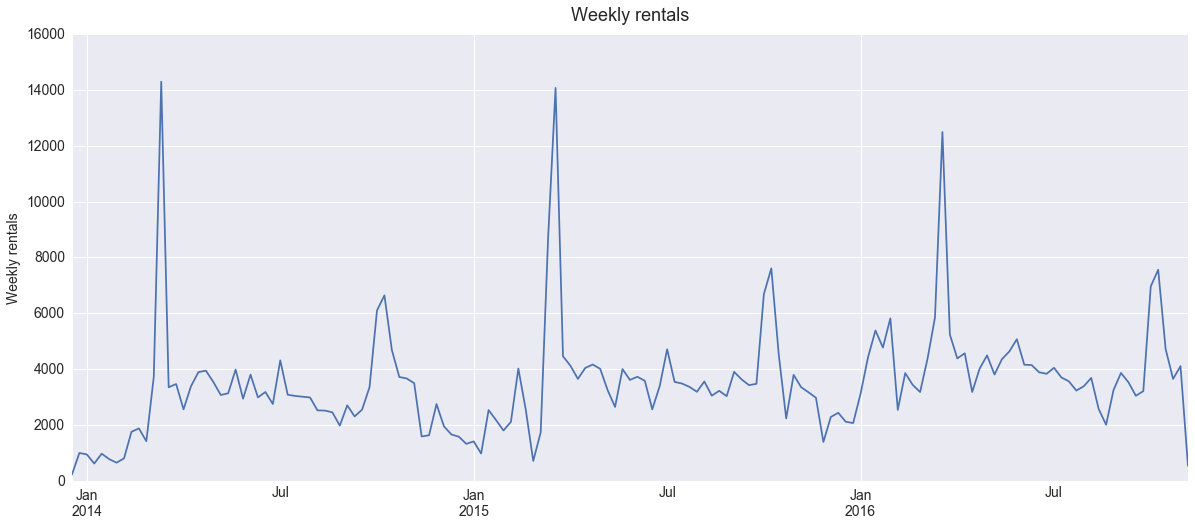

In [5]:
trip_df.resample('W').size().head()
plot_lines(trip_df.resample('W').size(), 
           plt.subplots(1,1, figsize=(20,8)), 
                        title='Weekly rentals', 
                        xlabel='', ylabel='Weekly rentals')



The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Processing Memberships

The BCycle Membership scheme has been revamped several times during the course of the program. To keep the analysis simple, let's group the membership types into the following categories. We'll use some regexes to combine the categories, to make it more readable I included '...' below to show it matches any following characters.

* `Single` <- 'Ridescout Single Ride', 'Try Before You Buy Special'
* `Day` <- '24-Hour ...', 'Explorer ...', 'Walk up ...'
* `Weekend` <- 'ACL Weekend Pass ...', 'FunFunFun ...', 'Weekender ...'
* `Weekly` <- '7-Day ...'
* `Monthly` <- 'Local30 ...'
* `Semester` <- 'Semester ...'
* `Annual` <- 'Annual ...', 'Local365 ...', 'Membership: pay once  one-year commitment', 'Republic Rider'
* `Tri-Annual` <- 'Founding Member ...'

There are a couple of other types labelled as `PROHIBITED` (8) and `RESTRICTED` (10). We'll drop these as there are only a small number of them, and many of these trips were 0 minutes long.

In [6]:
def clean_memberships(df, col):
    '''Cleans memberships by consolidating and converting to categories
    INPUT: df - pandas Dataframe containing membership columns
           col - column name to be consolidated
    RETURNS: pandas DataFrame with consolidated memberships'''
    
    # Replace the various memberships with their groupings
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['RideScout Single Ride','Try Before You Buy Special'], value='single')
    df[col] = df[col].replace(['^24-Hour.*$', '^Explorer.*$', '^Walk Up$'], value='day', regex=True)
    df[col] = df[col].replace(['^ACL Weekend Pass.*$', '^FunFunFun.*$', '^Weekender.*$'], value='weekend', regex=True)
    df[col] = df[col].replace(['^7-Day.*$'], value='week', regex=True)
    df[col] = df[col].replace(['^Local30.*$'], value='month', regex=True)
    df[col] = df[col].replace(['^Semester.*$'], value='semester', regex=True)
    df[col] = df[col].replace(['^Annual.*$', '^Local365.*$', 'Republic Rider.*$', '^Membership: pay once  one-year.*$'], value='year', regex=True)
    df[col] = df[col].replace(['^Founding Member.*$'], value='triannual', regex=True)

    # Drop the remaining trips (PROHIBITED and RESTRICTED)
    drop_mask = (df['membership'] == 'PROHIBITED') | (df['membership'] == 'RESTRICTED')
    df = df[~drop_mask]
    
    # Finally convert to categorical
    df[col] = df[col].astype('category')
    return df
    
trip_df = clean_memberships(trip_df, 'membership')

print(trip_df.groupby('membership').size())
print(trip_df.info())


membership
day          340573
month         26340
semester       3326
single          793
triannual      6288
week           5897
weekend       13323
year         133252
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529792 entries, 2013-12-21 09:09:00 to 2016-10-31 11:35:21
Data columns (total 5 columns):
membership        529792 non-null category
bike_id           529792 non-null object
checkout_kiosk    529792 non-null object
checkin_kiosk     529792 non-null object
duration          529792 non-null int64
dtypes: category(1), int64(1), object(3)
memory usage: 20.7+ MB
None


/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With the hard work out of the way, let's visualize the membership to see what's going on.

In [7]:
# plot_df = trip_df.copy()
# plot_df = plot_df.sort_index()
# plot_df = plot_df.pivot_table(values='bike_id', columns='membership', index=plot_df.index, aggfunc='count')
# plot_df = plot_df.fillna(0).astype(np.uint32)
# plot_df = plot_df.resample('W').sum()

# plot_df.plot.area()

### Processing Bike IDs

Now we need to convert the bike IDs to numeric values and convert to a categorical type. First of all let's check there aren't any non-numeric values in the dataset.

In [8]:
# Find all the bike_id values that aren't numeric
print('Checking for non-numeric bike ids:')
text_row_mask = trip_df['bike_id'].str.contains('\D')
text_bikes_df = trip_df[text_row_mask]
bike_str_ids = text_bikes_df['bike_id'].unique()
print('Found non-numeric bike ids: {}'.format(bike_str_ids))
# bike_str_ids = text_bikes_df['bike_id'].unique()
# bike_str_ids = text_bikes_df.groupby('bike_id').size()

Checking for non-numeric bike ids:
Found non-numeric bike ids: ['Block01' '198BB' 'Block03' 'Block05' 'Block02' 'Block04']


In [9]:
# Check how many `bike_id`s are non-numeric and drop them
n_rows = trip_df.shape[0]
n_str_rows = np.sum(text_row_mask)
pct_str_rows = (n_str_rows / n_rows) * 100.0
print('Total rows: {}\n'.format(n_rows))
print('Total non-numeric `bike_id` values: {} or {:.1f}%\n'.format(n_str_rows, pct_str_rows))
print('Non-numeric `bike_id` counts: \n{}'.format(text_bikes_df.groupby('bike_id').size()))

if n_str_rows != 0:
    trip_df = trip_df[~text_row_mask]
    assert np.sum(trip_df['bike_id'].str.contains('\D')) == 0, 'Error - still non-numeric bike_ids left !'
    
print('Max bike ID is {}'.format(trip_df['bike_id'].max()))
trip_df['bike_id'] = trip_df['bike_id'].astype(np.uint16)
trip_df.head()
# for bike_str_id in bike_str_ids:
#     df = text_bikes_df[text_bikes_df['bike_id'] == bike_str_id][['bike_id', 'duration', 'checkout_kiosk', 'checkin_kiosk']]
#     print(df)

Total rows: 529792

Total non-numeric `bike_id` values: 725 or 0.1%

Non-numeric `bike_id` counts: 
bike_id
198BB      683
Block01      7
Block02     15
Block03      4
Block04     10
Block05      6
dtype: int64
Max bike ID is 999


,membership,bike_id,checkout_kiosk,checkin_kiosk,duration
datetime,,,,,
2013-12-21 09:09:00,triannual,966,4th & Congress,Republic Square,5
2013-12-21 18:36:00,year,453,South Congress & Elizabeth,5th & Bowie,10
2013-12-21 18:04:00,triannual,116,2nd & Congress,4th & Congress,5
2013-12-21 17:56:00,triannual,971,5th & Bowie,2nd & Congress,7
2013-12-21 17:49:00,day,14,Barton Springs & Riverside,City Hall / Lavaca & 2nd,6


count     408.000000
mean     1296.732843
std       294.603402
min        17.000000
25%      1208.750000
50%      1372.000000
75%      1476.000000
max      1728.000000
dtype: float64

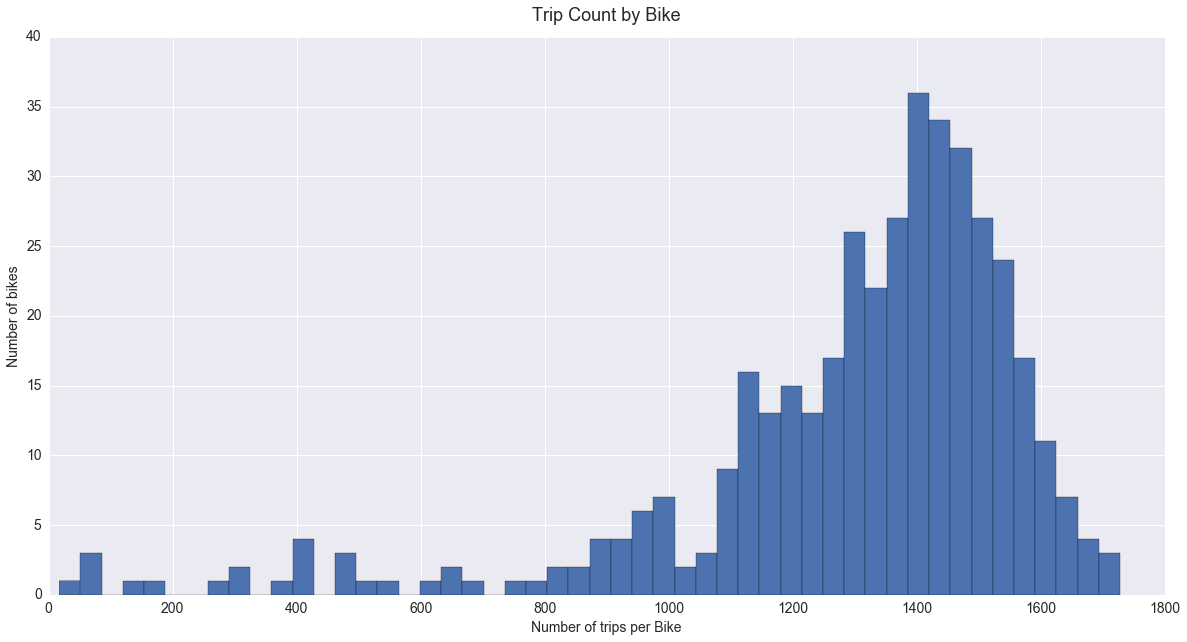

In [10]:
# Let's see how many times each of the bikes were rented out

def plot_hist(df_col, bins, size, title, xlabel, ylabel):
    '''Plots a histogram of the dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df_col.plot.hist(ax=ax, bins=bins)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   

bikes_df = trip_df.groupby('bike_id').size()
plot_hist(bikes_df, bins=50, size=(20,10), 
          title='Trip Count by Bike', 
          xlabel='Number of trips per Bike', 
          ylabel='Number of bikes')

bikes_df.describe()    

The histogram above shows that the most common number of trips for a given bike is around 1400. The distribution of trips per bike is left-skewed, with the Inter-Quartile-Range from 1208 to 1476 trips per bike. These bikes must be well maintained to make well over a thousand trips per bike !

# Processing stations

Now we need to convert the checkin and checkout kiosks into a categorical type instead of a string type. Let's do some checks to see what the overlap is like between checkin and checkout.

In [11]:
# Create a set of all the checkout and checkin kiosks. 
# If the sizes are different we have some checkin or checkout only ones.
checkins = set(trip_df['checkin_kiosk'].unique())
checkouts = set(trip_df['checkout_kiosk'].unique())

print('Number of unique checkin kiosks: {}, checkout kiosks: {}'.format(len(checkins), len(checkouts)))

Number of unique checkin kiosks: 83, checkout kiosks: 81


In [12]:
# Hmm ! Let's see which stations are in checkin and checkout, and which are in one only

def venn_stats(left, right, verbose=False, left_name=None, right_name=None):
    '''Creates Venn Diagram stats for two sets, left and right
    INPUTS: left = set of items on left
            right = set of items on right
            verbose = bool to print out set overlap and count info
            left_name = string used if verbose == True. Describes left set
            right_name = string used if verbose == True. Describes right set
    '''
    left_only = left - right
    left_and_right = left & right
    right_only = right - left
    
    if verbose:
        print('{} size = {}, {} size = {}'.format(left_name, len(left), right_name, len(right)))
        print('\nIntersection of {} and {} ({}):\n{}'.format(left_name, right_name, len(left_and_right), left_and_right))
        print('\n{}-only ({}):\n{}'.format(left_name, len(left_only), left_only))
        print('\n{}-only ({}):\n{}'.format(right_name, len(right_only), right_only))

    return (left_only, left_and_right, right_only)

venn_stations = venn_stats(checkouts, checkins, 
                          verbose=True, left_name='checkout', right_name='checkin')

checkout_only_stations, common_stations, checkin_only_stations = venn_stations

checkout size = 81, checkin size = 83

Intersection of checkout and checkin (80):
{'Republic Square @ Guadalupe & 4th St.', 'Lavaca & 6th', '2nd & Congress', 'Pease Park', 'Mobile Station @ Boardwalk Opening Ceremony', 'San Jacinto & 8th Street', 'Convention Center/ 3rd & Trinity', 'Barton Springs @ Kinney Ave', 'Palmer Auditorium', 'East 6th at Robert Martinez', 'Republic Square', 'Convention Center / 4th St. @ MetroRail', 'Republic Square @ Federal Courthouse Plaza', 'Red River @ LBJ Library', 'Nueces @ 3rd', 'ACC - Rio Grande & 12th', 'UT West Mall @ Guadalupe', 'Zilker Park at Barton Springs & William Barton Drive', 'Pfluger Bridge @ W 2nd Street', 'ACC - West & 12th Street', 'Plaza Saltillo', '17th & Guadalupe', '4th & Congress', 'South Congress & James', 'Mobile Station @ Bike Fest', 'Rainey St @ Cummings', 'Convention Center / 3rd & Trinity', 'MapJam at Hops & Grain Brewery', 'Long Center @ South 1st & Riverside', 'Capitol Station / Congress & 11th', 'MoPac Pedestrian Bridge @ V

## Checkin-only and checkout-only stations

Let's see how many trips use checkin-only or checkout-only stations. If there are only a small proportion, we can drop these. Otherwise we need to include them (but there's no obvious reason why a station would be checkin or checkout only).

In [13]:
# Let's deal with the checkin and checkout only stations
checkout_only_mask = trip_df['checkout_kiosk'].isin(checkout_only_stations)
checkout_only_count = np.sum(checkout_only_mask)
all_rows_count = trip_df.shape[0]
checkout_only_pct = (checkout_only_count / all_rows_count) * 100.0
checkout_only_df = trip_df[checkout_only_mask]
print('Number of checkout-only rows: {}, {:.4f}% of total'.format(checkout_only_count, checkout_only_pct))

if checkout_only_count > 0:
    trip_df = trip_df[~checkout_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkout_only_df.groupby('checkout_kiosk').size()

Number of checkout-only rows: 8, 0.0015% of total
Trips Dataframe shape is (529059, 5)


checkout_kiosk
Fantasy Zilker    8
dtype: int64

The stations above are only in the `checkout_kiosk` column, and never in the `checkin_kiosk` column. There are only 8 rows, which all leave from 'Fantasy Zilker' in the first 2 weekends of October 2016. I suspect this might be a special event held in Zilker Part. As there are only 8 of these rows, we can drop them from the dataset.

In [14]:
checkin_only_mask = trip_df['checkin_kiosk'].isin(checkin_only_stations)
checkin_only_count = np.sum(checkin_only_mask)
all_rows_count = trip_df.shape[0]
checkin_only_pct = (checkin_only_count / all_rows_count) * 100.0
checkin_only_df = trip_df[checkin_only_mask]
print('Number of checkin-only rows: {}'.format(checkin_only_df.shape[0]))

if checkin_only_count > 0:
    trip_df = trip_df[~checkin_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkin_only_df.groupby('checkin_kiosk').size()

Number of checkin-only rows: 65
Trips Dataframe shape is (528994, 5)


checkin_kiosk
Main Shop     2
Missing      25
Stolen       38
dtype: int64

There are only 65 checkin-only rows, from one of the three types: Main Shop, Missing, and Stolen. I think the 'Main Shop' ones might have been returned to the BCycle maintenance office for repair. I suspect the Stolen bikes are those that were stolen and returned by the Police. The 'Missing' ones must be the ones that have gone missing, but not yet returned. We can drop these rows.

## Counting checkins and checkouts at stations

Now we're left with only stations that are in both the checkout and checkin columns on the full dataset. We can count up all the checkins and checkouts at each of the stations. Let's create this dataframe, and then create a barplot to see how the checkouts and checkins vary by station.

In [15]:
# First up, count how many checkins and checkouts are done at each station and combine into a dataframe
checkouts_df = trip_df.groupby('checkout_kiosk').size().to_frame('checkouts').reset_index()
checkins_df = trip_df.groupby('checkin_kiosk').size().to_frame('checkins').reset_index()
station_df = pd.merge(checkins_df, checkouts_df, left_on='checkin_kiosk', right_on='checkout_kiosk')
station_df = station_df.drop('checkout_kiosk', axis=1)
station_df.columns = ['name', 'checkins', 'checkouts']
station_df['total'] = station_df['checkins'] + station_df['checkouts']
station_df = station_df.sort_values('total', ascending=False)
station_df.head()

,name,checkins,checkouts,total
20,City Hall / Lavaca & 2nd,28242,24196,52438
62,Riverside @ S. Lamar,22764,23454,46218
2,2nd & Congress,24081,21670,45751
4,4th & Congress,23653,21015,44668
5,5th & Bowie,21231,22734,43965


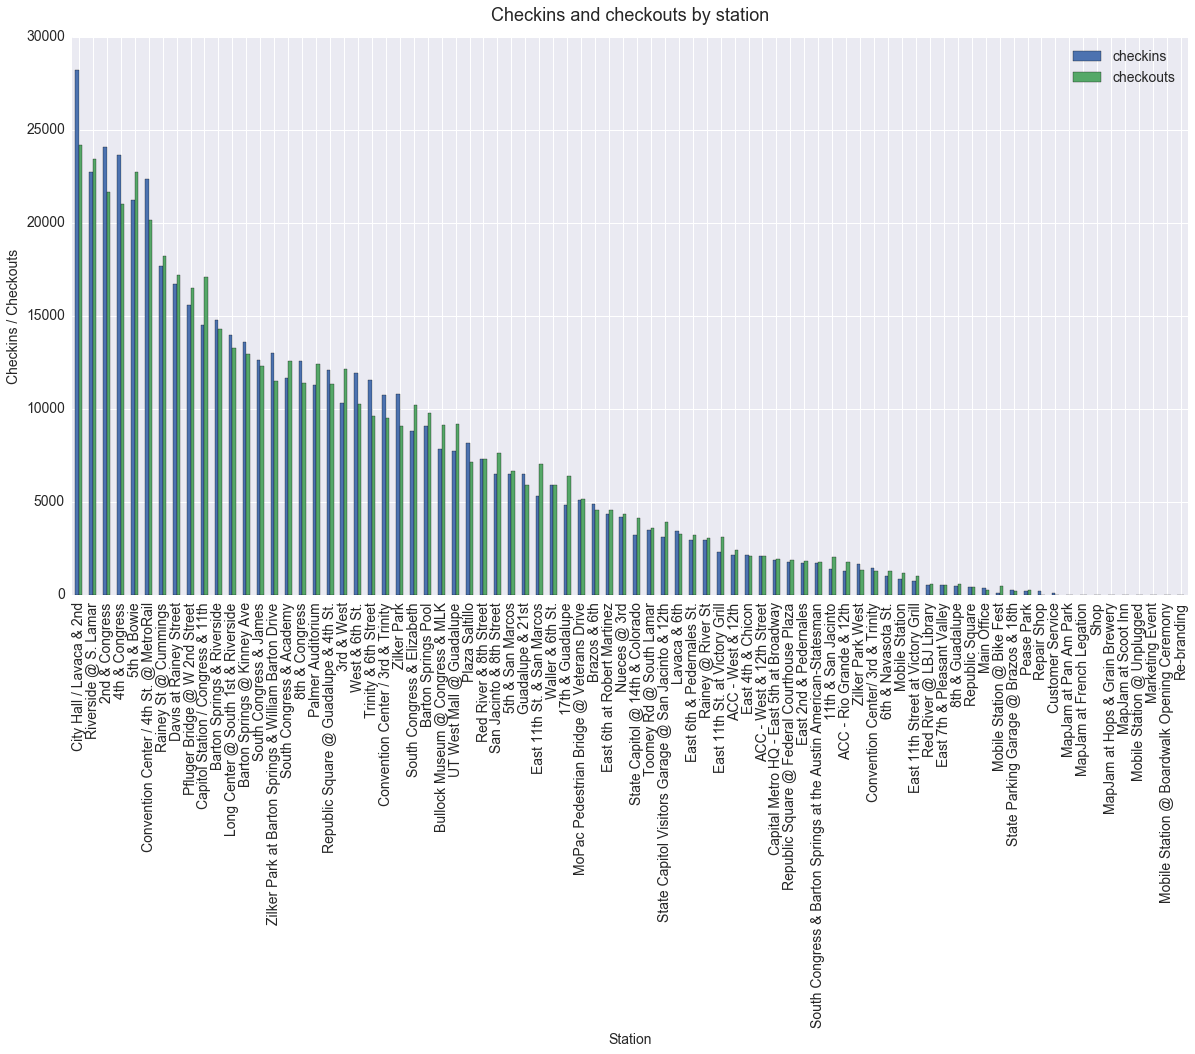

In [16]:
# Create a bar plot of the checkins and checkouts per station
def plot_bar(df, x, y, size, title, xlabel, ylabel):
    '''Plots a bar-graph of dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df.plot.bar(ax=ax, x=x, y=y)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.legend(fontsize = 14)


plot_bar(station_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Checkins and checkouts by station',
        xlabel='Station', ylabel='Checkins / Checkouts')


This is a very busy plot, and too condensed to easily read the station names. But you can see the rough distribution of checkins and checkouts from the busiest stations (City Hall, Riverside @ S. Lamar, 2nd & Congress, etc) down to the quietest stations ('Marketing Event', 'Mobile Station @ Boardwalk Opening', 'Re-branding'). As you get to the quieter stations, they seem to be temporary stations at events, or codenames for maintenance on the bikes: 'Shop'.

In [17]:
station_df

,name,checkins,checkouts,total
20,City Hall / Lavaca & 2nd,28242,24196,52438
62,Riverside @ S. Lamar,22764,23454,46218
2,2nd & Congress,24081,21670,45751
4,4th & Congress,23653,21015,44668
5,5th & Bowie,21231,22734,43965
22,Convention Center / 4th St. @ MetroRail,22380,20157,42537
54,Rainey St @ Cummings,17693,18258,35951
25,Davis at Rainey Street,16748,17214,33962
51,Pfluger Bridge @ W 2nd Street,15621,16510,32131
19,Capitol Station / Congress & 11th,14518,17114,31632


In [46]:
# Now let's print out all the stations, and drop ones which seem temporary

def remove_rows(df, col, words, verbose=False):
    '''Removes rows containing words given
    INPUT: df - dataframe
           words - iterable containing words
    RETURNS: Dataframe with rows containing `words` removed
    '''
    new_df = df.copy()
    for word in words:
        drop_mask = new_df[col].str.contains(word)
        drop_count = np.sum(drop_mask)
        drop_df = new_df[drop_mask]
        print('Dropping {} rows containing {}:\n{}'.format(drop_count, word, drop_df[col]))
        if (drop_count > 0):
            new_df = new_df[~drop_mask]
    return new_df


station_df = remove_rows(station_df, 'name', 
                 ['MapJam', 'Mobile', 'Shop', 'Marketing', 'Re-branding', 
                  'Customer Service', 'Main Office'],
                 verbose=True)
station_df = station_df.sort_values('name')
station_df['station_id'] = range(station_df.shape[0])
station_df['station_id'] = station_df['station_id'] + 1
station_df

Dropping 0 rows containing MapJam:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Mobile:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Shop:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Marketing:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Re-branding:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Customer Service:
Series([], Name: name, dtype: object)
Dropping 0 rows containing Main Office:
Series([], Name: name, dtype: object)


,name,checkins,checkouts,total,geocode_lat_lon,station_id
0,11th & San Jacinto,1430,2060,3490,"(30.27206, -97.738653)",1
1,17th & Guadalupe,4868,6415,11283,"(30.2797293, -97.74231470000001)",2
2,2nd & Congress,24081,21670,45751,"(30.26431999999999, -97.744197)",3
3,3rd & West,10320,12161,22481,"(30.2676417, -97.75155889999999)",4
4,4th & Congress,23653,21015,44668,"(30.2662006, -97.74348789999999)",5
5,5th & Bowie,21231,22734,43965,"(30.269738, -97.75317)",6
6,5th & San Marcos,6527,6690,13217,"(30.2641906, -97.7329652)",7
7,6th & Navasota St.,1028,1297,2325,"(30.2637215, -97.728495)",8
8,8th & Congress,12615,11416,24031,"(30.2699197, -97.7421066)",9
9,8th & Guadalupe,516,586,1102,"(30.2708968, -97.7455899)",10


Looking at the bottom stations, it looks like they're all temporary events that don't correspond to actual stations in the BCycle network. Let's see if we can drop these stations.

In [53]:
norm_trip_df = pd.merge(trip_df.reset_index(), station_df[['name', 'station_id']], left_on='checkout_kiosk', right_on='name')
norm_trip_df = pd.merge(norm_trip_df, station_df[['name', 'station_id']], left_on='checkin_kiosk', right_on='name')
norm_trip_df = norm_trip_df[['datetime', 'membership', 'bike_id', 'station_id_x', 'station_id_y', 'duration']]
norm_trip_df = norm_trip_df.rename(columns={'station_id_x' : 'checkout_id', 'station_id_y' : 'checkin_id'})
norm_trip_df = norm_trip_df.sort_values('datetime')
norm_trip_df = norm_trip_df.set_index('datetime', drop=True)
# norm_trip_df

,membership,bike_id,checkout_id,checkin_id,duration
datetime,,,,,
2013-12-21 09:09:00,triannual,966,5,47,5
2013-12-21 09:11:00,year,36,9,20,5
2013-12-21 10:09:00,day,101,47,55,19
2013-12-21 13:48:00,day,252,20,20,4
2013-12-21 13:51:00,day,287,6,5,12
2013-12-21 13:54:00,day,252,20,20,1
2013-12-21 13:56:00,day,125,20,20,9
2013-12-21 14:17:00,day,287,5,6,5
2013-12-21 14:19:00,year,80,47,6,3


# Save out dataframes to pickle files

Now we have the trips and stations dataframes normalized, we can save them out to load in other scripts.

In [55]:
import pickle

# Save out the trips and stations dataframe
pickle.dump(trip_df, open('../input/trip.pkl', 'wb'))
pickle.dump(station_df, open('../input/station.pkl', 'wb'))

# Adding metadata to stations dataframe

Now we have the stations table separated from the trips, we can add in metadata for the longitude and latitude of each of the stations. These can come from a combination of:

* The Austin Bcycle station: This can be parsed to extract the stations and matched based on the names.
* Google's geocoder: We can fill in any stations not currently on the webpage using geocoding.

In [120]:
import requests
from bs4 import BeautifulSoup
from lxml import html



r = requests.get('https://austin.bcycle.com/stations/station-locations', stream=True)

for line in r.iter_lines():

    # filter out keep-alive new lines
    if line:
        decoded_line = line.decode('utf-8')
        print(decoded_line)



<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js">
<!--<![endif]-->
<head id="head"><meta http-equiv="content-type" content="text/html; charset=utf-8" /><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" /><meta name="viewport" content="width=device-width, initial-scale=1.0" />
<meta name="HandheldFriendly" content="True" />
<meta http-equiv="cleartype" content="on" />
<meta name="description" content="Description" />
<meta name="application-name" content="Website application name shown above taskbar preview" />
<meta name="msapplication-tooltip" content="Additional tooltip text" />
<meta name="msapplication-window" content="width=1024;height=768" />
<meta name="msapplication-starturl" content="./" />
<meta name="msapplication-navbutton-color" content="#E72

In [139]:

LAT_IDX = 0
LONG_IDX = 1

STAT_NAME = 0
STAT_ADDRESS = 1
STAT_BIKES = 2
STAT_DOCKS = 3


date_re = re.compile('.*stations_(\d{4}-\d{2}-\d{2}).*\.html')
time_re = re.compile('.*stations_\d{4}-\d{2}-\d{2}_(\d{2}:\d{2}:)\d{2}.*\.html')
station_re = re.compile('^var marker = new createMarker\(point, \"<div class=\'markerTitle\'><h3>(\w.*)</h3></div>\
<div class=\'markerPublicText\'><h5></h5></div>\
<div class=\'markerAddress\'>(\w.*)</div><div class=\'markerAvail\'>\
<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Bikes</div>\
<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Docks</div></div>\"')
latlong_re = re.compile('var point = new google\.maps\.LatLng\((.+), (.+)\);')

# Dictionary to store stations (fast lookup by lat/lon)
stations = dict()
station_id = 1
# List to store the bike values for each station in a series
bike_list = list()

r = requests.get('https://austin.bcycle.com/stations/station-locations', stream=True)

verbose = True

for line in r.iter_lines():
    if line:
        decoded_line = line.decode('utf-8'
                                  )
        # Check for latitude and longitude
        match = latlong_re.match(decoded_line)
        if (match != None):
            latitude = float(latlong_re.match(decoded_line).groups()[LAT_IDX])
            longitude = float(latlong_re.match(decoded_line).groups()[LONG_IDX])
            latlon = (latitude, longitude)
            if verbose:
                print('Found lat {}, lon {}'.format(latitude, longitude))

        match = station_re.match(decoded_line)
        if (match != None):

            name = str(station_re.match(decoded_line).groups()[STAT_NAME])
            address = str(station_re.match(decoded_line).groups()[STAT_ADDRESS].replace('<br />', ', '))
            bikes = int(station_re.match(decoded_line).groups()[STAT_BIKES])
            docks = int(station_re.match(decoded_line).groups()[STAT_DOCKS])

            if (latlon not in stations):
                new_station = dict()
                new_station['station_id'] = station_id
                new_station['name'] = name
                new_station['address'] = address
                new_station['lat'] = latitude
                new_station['lon'] = longitude
#                 new_station['datetime'] = datetime_string
                stations[latlon] = new_station

                station_id += 1
                if verbose:
                    print('Adding new station: {}'.format(new_station))

                    
print('Found {} stations'.format(len(stations)))

# print('Converting station and bike data to csv file')
#
# # Convert to pandas dataframes
# # stations_inv_dict = {v: k for k, v in stations_dict.items()}
stations_df = pd.DataFrame.from_dict(stations, orient='index')
stations_df = stations_df[['station_id', 'name', 'address', 'lat', 'lon']]
# stations_df = stations_df.sort_values('station_id', ascending=True)
stations_df = stations_df.reset_index(drop=True)
stations_df

Found lat 30.26408, lon -97.74355
Adding new station: {'station_id': 1, 'lon': -97.74355, 'address': '151 E. 2nd St, Austin, TX 78701', 'name': '2nd & Congress', 'lat': 30.26408}
Found lat 30.26634, lon -97.74378
Adding new station: {'station_id': 2, 'lon': -97.74378, 'address': '120 W. 4th St., Austin, TX 78701', 'name': '4th & Congress', 'lat': 30.26634}
Found lat 30.26978, lon -97.74224
Adding new station: {'station_id': 3, 'lon': -97.74224, 'address': '111 E. 8th St., Austin, TX 78701', 'name': '8th & Congress', 'lat': 30.26978}
Found lat 30.2726, lon -97.74127
Adding new station: {'station_id': 4, 'lon': -97.74127, 'address': '1090 Congress Ave., Austin, TX 78701', 'name': 'Capitol Station / Congress & 11th', 'lat': 30.2726}
Found lat 30.26483, lon -97.739
Found lat 30.26476, lon -97.74678
Adding new station: {'station_id': 5, 'lon': -97.74678, 'address': 'Presented by Graves Dougherty Hearon & Moody, Austin, TX 78701', 'name': 'City Hall / Lavaca & 2nd', 'lat': 30.26476}
Found la

,station_id,name,address,lat,lon
0,9,South Congress & Elizabeth,"101 Elizabeth St. W, Austin, TX 78704",30.24891,-97.75019
1,8,South Congress & James,"Presented by The Austin Chronicle, Austin, TX ...",30.25103,-97.74926
2,30,South Congress & Academy,"1199 S. Congress Ave., Austin, TX 78704",30.25222,-97.74881
3,41,East 2nd & Pedernales,"2414 E 2nd St, Austin, TX 78702",30.25542,-97.71665
4,35,Rainey St @ Cummings,"1 Rainey St, Austin, TX 78701",30.25579,-97.73982
5,38,Capital Metro HQ - East 5th at Broadway,"2910 E 5th St, Austin, TX 78702",30.25630,-97.71007
6,47,South Congress & Barton Springs at the Austin ...,"305 S. Congress Ave., Austin, TX 78704",30.25839,-97.74592
7,7,Barton Springs & Riverside,"400 Barton Springs Rd., Austin, TX 78704",30.25870,-97.74872
8,16,East 6th & Pedernales St.,"2498 E. 6th St., Austin, TX 78702",30.25895,-97.71475
9,19,Long Center @ South 1st & Riverside,"Presented by Austin Energy, Austin, TX 78704",30.25941,-97.74971


# js_text = soup.find('script', type="text/javascript").text
js_text

In [77]:
soup.prettify()

'<!DOCTYPE html>\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!-->\n<html class="no-js">\n <!--<![endif]-->\n <head id="head">\n  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>\n  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>\n  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>\n  <meta content="True" name="HandheldFriendly"/>\n  <meta content="on" http-equiv="cleartype"/>\n  <meta content="Description" name="description"/>\n  <meta content="Website application name shown above taskbar preview" name="application-name"/>\n  <meta content="Additional tooltip text" name="msapplication-tooltip"/>\n  <meta content="width=1024;height=768" name="msapplication-window"/>\n  <meta content="./" name="msapplication-starturl"/>\n  <meta content="#E72C

# Using scraped station information to complete stations dataframe

Now we have a clean set of stations that are in both checkin and checkout stations, we can re-use the station information from the scraped dataset to add in details about their latitude and longitude. We then need to geocode stations that are only in the full dataset to get their position. 

Once we have the details about all the stations, we can label each with a `station_id`. Then we can replace the `checkin_kiosk` and `checkout_kiosk` columns with that `station_id` to normalize the time-varying trips dataframe. Let's get started !

In [20]:
# Read in the scraped stations, and create a set of the station names.
scrape_stations_df = pd.read_csv('../input/stations.csv')
scrape_stations = set(scrape_stations_df['name'])

# Now work out which stations are in the full dataset, but not the scraped one.
# These are the stations we need to fill in position information for.
all_stations = set(station_df['name'])

venn_stations = venn_stats(scrape_stations, all_stations, verbose=True,
                           left_name='scraped stations', right_name='all_data stations')

scrape_only, common, all_only = venn_stations

scraped stations size = 50, all_data stations size = 80

Intersection of scraped stations and all_data stations (50):
{'Republic Square @ Guadalupe & 4th St.', 'Lavaca & 6th', '2nd & Congress', 'Pease Park', 'San Jacinto & 8th Street', 'Barton Springs @ Kinney Ave', 'Palmer Auditorium', 'East 6th at Robert Martinez', 'Republic Square', 'UT West Mall @ Guadalupe', 'Pfluger Bridge @ W 2nd Street', 'ACC - West & 12th Street', 'Plaza Saltillo', '17th & Guadalupe', '4th & Congress', 'South Congress & James', 'Rainey St @ Cummings', 'Convention Center / 3rd & Trinity', 'Long Center @ South 1st & Riverside', 'Capitol Station / Congress & 11th', 'MoPac Pedestrian Bridge @ Veterans Drive', 'Bullock Museum @ Congress & MLK', '3rd & West', 'South Congress & Elizabeth', 'State Capitol @ 14th & Colorado', 'Riverside @ S. Lamar', 'Brazos & 6th', 'Barton Springs & Riverside', 'East 6th & Pedernales St.', '8th & Congress', 'East 4th & Chicon', '5th & Bowie', 'City Hall / Lavaca & 2nd', '5th & San Marc

There are 29 stations which are only in the full bike trips dataset `checkin_kiosk` or `checkout_kiosk` columns. That means we only have a name for these `all_data` stations, and no position information. 

## Plotting checkins and checkouts for stations only in full bike trips dataset

Let's examine the information for stations that are only in the bike trips full dataset. These may be stations that weren't in use during the April and May 2016 web-scraping timeframe and were missed because of that. They could also be older stations that moved locations and were renamed, or temporary stations for a special event.

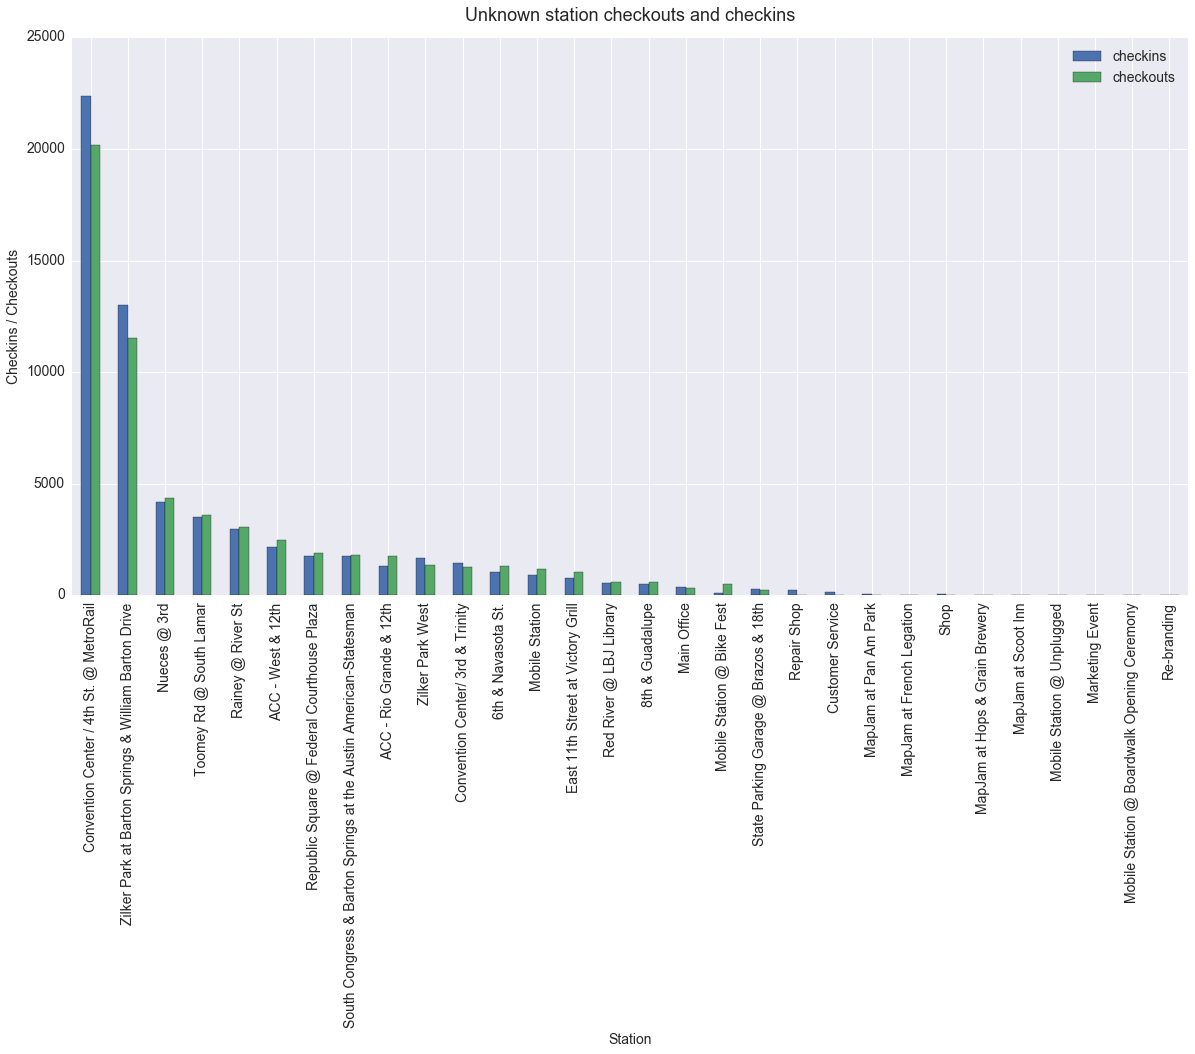

In [21]:
# now we have a set in `all_only` that contains stations we don't have information for. 
# Let's see how many stations are in there
all_only_stations_df = station_df[station_df['name'].isin(all_only)]
all_only_stations_df

plot_bar(all_only_stations_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Unknown station checkouts and checkins',
        xlabel='Station', ylabel='Checkins / Checkouts')



### Adding in latitude and longitude of stations in the full dataset only

For stations which are only in the full BCycle dataset, we don't have any position information. The only information we do have is their name, copied from the `checkout_kiosk` or `checkin_kiosk` columns in the original trip data.

If we have their latitude and longitude we can plot them on maps and treat them like the stations in the 2-month scraped dataset. Let's clean up their names, and then geocode to get lat/lon pairs.

In [22]:
# We need to get a lat/lon pair for each of these unknown stations, and create a superset stations 
# dataframe from the 2-month April/May data and all of these extra ones

from pygeocoder import Geocoder
import re

def geocode(location, verbose=False, dry_run=False):
    '''Tries to geocode a location, returns None if no matches
    INPUT: location - string containing the location
    RETURNS: tuple of (latitude, longitude) if successful, None if not
    '''
    for end in ('rd', 'st', 'th'):
        location = re.sub(end + '$', end + ' Street', location)

    location = re.sub('^ACC - ', '', location)
    location = re.sub('at the \D.*$', '', location)
    location = re.sub('^Convention Center/', '', location)
    location = re.sub('^State Parking Garage @', '', location)
    location += ', Austin TX' # Add this on the end to help !
    
    if dry_run:
        return location
    
    try:
        result = Geocoder.geocode(location)
        if verbose:
            print('Returned {} geocode as {}'.format(location, result.coordinates))
        return result.coordinates
    
    except Exception as e:
        print('** Error finding geocode for {}'.format(location))
        return None

station_df['geocode_lat_lon'] = station_df['name'].apply(
                                          lambda x: geocode(x, verbose=True, dry_run=False))

total = all_only_stations_df.shape[0]
geocode_count = stations_df['geocode_lat_lon'].notnull().sum()
geocode_pct = (geocode_count / total) * 100.0

print('Geocoded {} of {} rows ({:.2f}%)'.format(geocode_count, total, geocode_pct))
print('Missing geocodes:')
all_only_stations_df[all_only_stations_df['geocode_lat_lon'].isnull()]


** Error finding geocode for City Hall / Lavaca & 2nd, Austin TX
Returned Riverside @ S. Lamar, Austin TX geocode as (30.264527, -97.7570554)
Returned 2nd & Congress, Austin TX geocode as (30.26431999999999, -97.744197)
Returned 4th & Congress, Austin TX geocode as (30.2662006, -97.74348789999999)
Returned 5th & Bowie, Austin TX geocode as (30.269738, -97.75317)
Returned Convention Center / 4th St. @ MetroRail, Austin TX geocode as (30.265012, -97.739296)
Returned Rainey St @ Cummings, Austin TX geocode as (30.2557809, -97.7398671)
Returned Davis at Rainey Street, Austin TX geocode as (30.2600925, -97.7382928)
Returned Pfluger Bridge @ W 2nd Street, Austin TX geocode as (30.43878849999999, -97.622851)
** Error finding geocode for Capitol Station / Congress & 11th Street, Austin TX
Returned Barton Springs & Riverside, Austin TX geocode as (30.2586503, -97.7484795)
** Error finding geocode for Long Center @ South 1st & Riverside, Austin TX
Returned Barton Springs @ Kinney Ave, Austin TX 

NameError: name 'stations_df' is not defined

In [ ]:
# Show the remaining stations in the full dataset that couldn't be geocoded.
no_geocode_mask = all_only_stations_df['geocode_lat_lon'].isnull()
all_only_stations_df[no_geocode_mask]

# These are all mobile or invalid stations, so drop them.
all_only_stations_df = all_only_stations_df[~no_geocode_mask]
# Drop any rows with MapJam in them (it's a music festival, not a station)
mapjam_mask = all_only_stations_df['station'].str.contains('MapJam')
all_only_stations_df = all_only_stations_df[~mapjam_mask]

all_only_stations_df

In [ ]:
# Now let's combine the 2-month stations with the full dataset stations 

# First transform the columns of the full dataset stations to match the scraped one
# all_only_stations_df = all_only_stations_df.drop(['checkins', 'checkouts', 'total'])
all_only_stations_df['lat'] = all_only_stations_df['geocode_lat_lon'].apply(lambda x: x[0])
all_only_stations_df['lon'] = all_only_stations_df['geocode_lat_lon'].apply(lambda x: x[1])
all_only_stations_df['name'] = all_only_stations_df['station']
all_only_stations_df = all_only_stations_df[['name', 'address', 'lat', 'lon', 'datetime']]
all_only_stations_df
# scrape_stations_df.head()



In [ ]:
# Combine the scraped and full data stations together
all_stations_df = pd.concat((scrape_stations_df, all_only_stations_df), axis=0)


all_stations_df

# Trip Duration

Let's take a look at the distribution of trip durations, to see if there's anything fishy in there.

In [ ]:
# Non-sensical trip durations.

# How many trips are 0 minutes long?
zero_trips_df = trip_df[trip_df['duration'] == 0]


zero_trips_df.head()


# # Plot a histogram of log trip durations using log transformation
# trip_df['log_duration'] = trip_df['duration'].apply(np.log10)
# plot_hist(trip_df['duration'], bins=50, size=(20,10), 
#           title='Bike Trip Count', 
#           xlabel='Number of trips per Bike', 
#           ylabel='Count')




In [ ]:
# trip_df['duration'].plot.hist()
trip_df['duration'].describe()
trip_df['log_duration'] = trip_df['duration'].apply(np.log10)
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=trip_df, x='membership', y='log_duration', ax=ax)
# plot_hist(bikes_df, bins=50, size=(20,10), 
#           title='Bike Trip Count', 
#           xlabel='Number of trips per Bike', 
#           ylabel='Count')




In [ ]:
trip_df.head()

In [ ]:
print(plot_df.shape)